# Shor's factorization algorithm

We need to decompose $N=pq$. Best [Shank's](https://en.wikipedia.org/wiki/Shanks%27s_square_forms_factorization) and [Pollard-Strassen](https://ru.wikipedia.org/wiki/%D0%90%D0%BB%D0%B3%D0%BE%D1%80%D0%B8%D1%82%D0%BC_%D0%9F%D0%BE%D0%BB%D0%BB%D0%B0%D1%80%D0%B4%D0%B0_%E2%80%94_%D0%A8%D1%82%D1%80%D0%B0%D1%81%D1%81%D0%B5%D0%BD%D0%B0) algorithms do this in $\mathcal{O}(N^{1/4})$. Can we do better?

## Classic idea of the method

### Exponential function

Assume we have $0<a<N$ which is co-prime to $N$: $gcd(N, a) = 1$.

Then by number theory $f(x) = a^x \mod N$ is a periodic function. Implement to justify this visually.

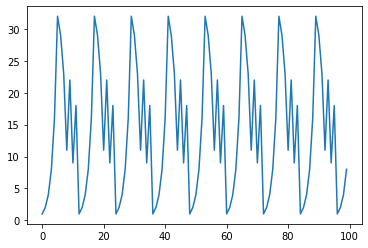

In [1]:
def f(x, a, N):
    # TODO your code here

N = 35
a = 2
data = [f(i, a, N) for i in range(100)]

import matplotlib.pyplot as plt

plt.plot(data)
plt.show()

### Function period

We can find a period $r$ of this function:

$a^x=a^{x+r}\mod N$

easily, using obvious trick:

$a^0=1$. Thus $a^{0+r}=a^r=1\mod N$.

Let's find $r$.

In [2]:
def get_period(f, hardstop=100):
    # TODO your code here

In [3]:
victim = lambda x: f(x, a, N)
assert get_period(victim) == 12, "Wrong implementation"

### Using a period $r$ for $p$ and $q$ estimation.

For this we will need an implementation of `gcd` function. Hopefully, we can use [Euclidean algorithm](https://en.wikipedia.org/wiki/Euclidean_algorithm).

In [4]:
def gcd(a, b):
    # TODO your code here
    return a

In [5]:
assert gcd(121, 132) == 11, "Wrong algorithm"

It appears that (with respect to some limitations and probabilities) $p$ and $q$ can be computed as $\gcd(N, a^{r/2}\pm 1)$.

In [6]:
def factor(N, a, r):
    return gcd(N, a ** (r // 2) - 1), gcd(N, a ** (r // 2) + 1)

In [7]:
N = 11 * 17
a = 2
factor(N, a, get_period(lambda x: f(x, a, N)))

(11, 17)

## Shor 0.1: alpha
Circular bit shift multiplication by 2.

In [12]:
def circ(x):
    return x[1:] + x[:1]

x = '0010'
for i in range(8):
    print(x, "~", int(x, base=2))
    x = circ(x)

0010 ~ 2
0100 ~ 4
1000 ~ 8
0001 ~ 1
0010 ~ 2
0100 ~ 4
1000 ~ 8
0001 ~ 1


We will use this property to represent $f(x)=2^x\mod 15$.

In [15]:
for i in range(8):
    print(f(i + 1, 2, 15))

2
4
8
1
2
4
8
1


### Let's do this in a circuit form.

Let $U_f$ be the function, which returns next sequence state:

$U_f|f(0)\rangle=|f(1)\rangle$

$U_f|f(1)\rangle=|f(2)\rangle$

...

$U_f^r|f(0)\rangle=|f(r)\rangle=|f(0)\rangle$

In [16]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, Aer, execute
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt

In [50]:
qx = QuantumRegister(4, name="x")
qf = QuantumRegister(4, name="f(x)")
cr = ClassicalRegister(4)

qc = QuantumCircuit(qx, qf, cr)

# TODO: prepare equal superposition for x

# TODO: prepare 0001 at f(x)

# TODO: implement controlled circular bit shift repeated power times
def CUf(power=1):
    qc = QuantumCircuit(5, name=f"CU^{power}f")
    # TODO your code here
    return qc
    
print("This is C-Uf:")
print(CUf().draw())

## THESE ARE FINAL STEPS:

# U^1
qc.append(CUf(), qf[:] + [qx[0]])
# U^2
qc.append(CUf(2 ** 1), qf[:] + [qx[1]])
# U^4
qc.append(CUf(2 ** 2), qf[:] + [qx[2]])
# U^8
qc.append(CUf(2 ** 3), qf[:] + [qx[3]])

from qiskit.circuit.library import QFT
qft4 = QFT(4)

qc.append(qft4, qx)
qc.measure(qx, cr)

print(qc.draw())

This is C-Uf:
              
q_0: ───────X─
            │ 
q_1: ────X──X─
         │  │ 
q_2: ─X──X──┼─
      │  │  │ 
q_3: ─X──┼──┼─
      │  │  │ 
q_4: ─■──■──■─
              
        ┌───┐ ░       ░ ┌────────┐                              ┌──────┐┌─┐   »
   x_0: ┤ H ├─░───────░─┤4       ├──────────────────────────────┤0     ├┤M├───»
        ├───┤ ░       ░ │        │┌────────┐                    │      │└╥┘┌─┐»
   x_1: ┤ H ├─░───────░─┤        ├┤4       ├────────────────────┤1     ├─╫─┤M├»
        ├───┤ ░       ░ │        ││        │┌────────┐          │  QFT │ ║ └╥┘»
   x_2: ┤ H ├─░───────░─┤        ├┤        ├┤4       ├──────────┤2     ├─╫──╫─»
        ├───┤ ░       ░ │        ││        ││        │┌────────┐│      │ ║  ║ »
   x_3: ┤ H ├─░───────░─┤        ├┤        ├┤        ├┤4       ├┤3     ├─╫──╫─»
        └───┘ ░ ┌───┐ ░ │  CU^1f ││        ││        ││        │└──────┘ ║  ║ »
f(x)_0: ──────░─┤ X ├─░─┤0       ├┤0 CU^2f ├┤0       ├┤0       ├─────────╫──╫─»
              ░ └───┘

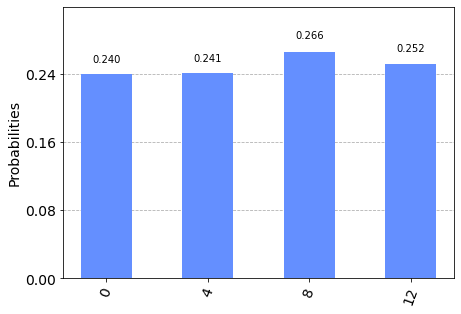

In [51]:
shots = 5000
job = execute(qc, Aer.get_backend('qasm_simulator'), shots=shots)
counts = job.result().get_counts(qc)
plot_histogram(dict((int(k, base=2), v) for (k, v) in counts.items()))

This code derived from [here](https://oreilly-qc.github.io/#) (I have no idea how) finds the denominanator which with a spike form a proper fraction. We provide the observed values of a single Shor's run and a size $2^{|X|}$.

In [52]:
def estimate_num_spikes(spike, max_value):
    if (spike < max_value / 2):
        spike = max_value - spike
    best_error = 1.0
    e0, e1, e2 = 0, 0, 0
    actual = spike / max_value
    candidates = []
    denom = 1.0
    while denom < spike:
        numerator = round(denom * actual)
        estimated = numerator / denom
        error = abs(estimated - actual)
        e0 = e1
        e1 = e2
        e2 = error

        ## Look for a local minimum which beats our
        ## current best error
        if e1 <= best_error and e1 < e0 and e1 < e2:
            repeat_period = denom - 1
            candidates.append(repeat_period)
            best_error = e1
        denom += 1
        
    return candidates

In [53]:
print(estimate_num_spikes(4, 2 ** 4))
print(estimate_num_spikes(8, 2 ** 4))
print(estimate_num_spikes(12, 2 ** 4))

[4.0, 8.0]
[2.0, 4.0, 6.0]
[4.0, 8.0]


In [ ]:
# if we observe 4:
factor(15, 2, 4)